# Sentence Segmentation for Chinese Classical Texts through the Implementation of Bi-LSTM Model

# data processing

In [32]:
import torch
from torch.nn.utils.rnn import pad_sequence
import re
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [33]:
def show_frequency(inputs):
  # 获取每个子列表的长度
  lengths = [len(sublist) for sublist in inputs]

  # 统计每个长度出现的频率
  frequency = {}
  for length in lengths:
      if length in frequency:
          frequency[length] += 1
      else:
          frequency[length] = 1

  # 提取长度和频率作为x和y轴数据
  x = list(frequency.keys())
  y = list(frequency.values())

  # 绘制频率直方图
  plt.bar(x, y)

  # 添加标题和轴标签
  plt.title("Frequency Histogram of Sublist Lengths")
  plt.xlabel("Length")
  plt.ylabel("Frequency")

  # 显示图形
  plt.show()

In [34]:
# 用`/`替代所有标点符号
def replace(text):
  text = re.sub(r'[，。《》()&#;``\[\]{}、；：“”‘’"\'!！?\n\u3000]', '/', text)
  text = re.sub(r'——','/',text)
  return text
sample = '孔子曰：学而时习之，不亦乐乎。仲尼曰：吾日三省吾身——为人谋而不忠乎？与朋友交而不信乎？传不习乎？'
seg_text = replace(sample)
print(seg_text)

孔子曰/学而时习之/不亦乐乎/仲尼曰/吾日三省吾身/为人谋而不忠乎？与朋友交而不信乎？传不习乎？


In [35]:
# 每个字都带上标签`/n`,`/s`
def creat_label(text):
  labels = []
  for i, char in enumerate(text):
      if char == '/':
        continue
      if i<len(text) - 1 and text[i+1] != '/':
          label = 'n'
      else:
          label = 's'
      labels.append((char, label))

  label_to_index = {'n': 0, 's': 1}

  # change 'n/s' label to '0/1' label
  label_indices = [label_to_index[label] for _, label in labels]

  return label_indices


In [36]:
# read data
# Open the file in read mode
file_path = "/content/前6-二十四史-已合并.txt"
dic = []
inputs = []
labels = []
with open(file_path, "r") as file:
  for line_number, line in enumerate(file):
    if line.strip() != "":
      seg_text = replace(line)

      sentence = [char for char in seg_text if char !='/']
      dic.extend(sentence)
      # y
      labels_indices = creat_label(seg_text)
      labels.append(labels_indices)
      # x
      inputs.append(sentence)



In [37]:
print(f'number of lines in original dataset:{len(inputs)}')

number of lines in original dataset:12558


In [38]:
# 获取词汇表（Word2Vec）
from gensim.models import Word2Vec
# words = [char for char in seg_text if char !='/']
Word2Vec_model = Word2Vec(sentences=[dic], vector_size=128, window=5, min_count=1, workers=4)

# 获取词汇表
vocab_list = list(Word2Vec_model.wv.index_to_key)
print(vocab_list)

# match each word with an index (int)
for i in range(0, len(inputs)):
  inputs[i] = [vocab_list.index(character) for character in inputs[i]]


['之', ' ', '以', '为', '不', '王', '曰', '而', '子', '其', '人', '也', '者', '有', '大', '于', '十', '年', '公', '下', '将', '军', '上', '太', '天', '所', '侯', '二', '后', '中', '与', '三', '至', '国', '使', '臣', '是', '帝', '相', '故', '事', '自', '乃', '得', '一', '无', '五', '言', '兵', '秦', '时', '皆', '百', '夫', '立', '行', '君', '诸', '汉', '阳', '四', '可', '出', '欲', '此', '长', '东', '及', '南', '见', '月', '齐', '则', '令', '千', '安', '入', '今', '数', '民', '平', '万', '日', '从', '复', '如', '？', '楚', '死', '道', '在', '能', '高', '六', '於', '闻', '西', '武', '文', '生', '明', '何', '地', '书', '世', '史', '成', '未', '赵', '城', '杀', '矣', '山', '然', '卒', '知', '元', '又', '北', '守', '封', '家', '士', '周', '亡', '郡', '方', '主', '用', '官', '非', '当', '先', '马', '已', '皇', '岁', '祖', '德', '尉', '吏', '遂', '居', '亦', '义', '司', '余', '食', '七', '孝', '氏', '九', '都', '治', '内', '谓', '因', '即', '功', '八', '去', '击', '常', '弟', '父', '等', '乎', '信', '河', '水', '必', '归', '名', '陵', '法', '多', '发', '定', '莽', '骑', '陈', '孙', '始', '州', '礼', '少', '师', '魏', '丞', '我', '来', '奴', '朝', '前', '位', '吾', '过', '里', '正', '反',

In [39]:
print(Word2Vec_model)

Word2Vec<vocab=6526, vector_size=128, alpha=0.025>


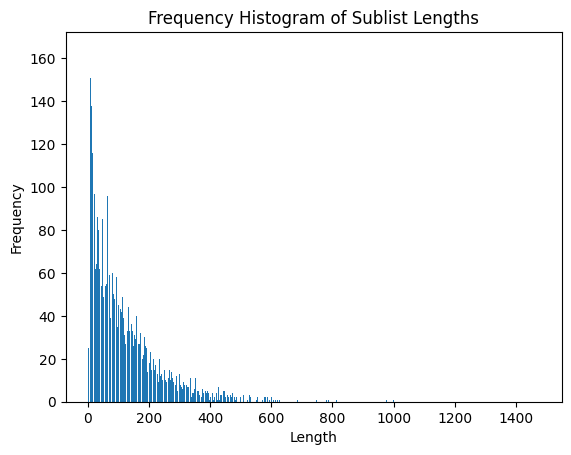

In [40]:
show_frequency(inputs)

In [41]:

filtered_inputs = [sublist for sublist in inputs if len(sublist) <= 400]
filtered_labels = [sublist for sublist in labels if len(sublist) <= 400]
inputs = filtered_inputs
labels = filtered_labels

In [42]:
print(f"number of lines of original data:{len(inputs)},length of filtered data:{len(filtered_inputs)}")

number of lines of original data:12204,length of filtered data:12204


In [43]:
padded_inputs = pad_sequence([torch.LongTensor(x) for x in inputs], batch_first=True, padding_value=0)
padded_labels = pad_sequence([torch.LongTensor(x) for x in labels], batch_first=True, padding_value=0)

In [44]:
# Split the dataset into training and validation sets(8:2)
valid_size = 0.2
num_dataset = len(padded_inputs)
split = int(np.floor(valid_size * num_dataset))
train_data = padded_inputs[split:]
valid_data = padded_inputs[:split]
train_labels = padded_labels[split:]
valid_labels = padded_labels[:split]

# Build and train the Bi-LSTN Model

* Loss -> Optimizer 算back propagation -> find out optimized (best) W (weight) and b  (bias) in the LSTM model.

In [45]:
# device
is_cuda = torch.cuda.is_available()

  # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [46]:
# 建立模型
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_classes, num_layers):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.dropout = nn.Dropout(0.5) # dropout=0.5，表示有很多个神经元中，每个神经元都有50%的几率不参与一个训练过程。
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size * 2, num_classes)# 将[row=40, column=128]转化为[row=40,column=1]矩阵

    def forward(self, x):
        embedded = self.embedding(x) # 在原本tensor的基础上再加一个embedd_dim维度
        lstm_out, hidden = self.lstm(embedded)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size*2) # 转变为[row=40, column=128]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, -1)
        return out

In [47]:
# 激活模型

# Set hyperparameters
vocab_size = len(vocab_list)
embedding_size = 128
hidden_size = 64
num_classes = 1  # Number of classes (in this case, 'n' or 's')，get value of probability
batch_size = 32
num_layers = 2
learning_rate = 0.01

model = BiLSTMModel(vocab_size, embedding_size, hidden_size, num_classes, num_layers)
model.to(device)

# load data
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

valid_dataset = TensorDataset(valid_data, valid_labels)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

# Loss function and optimizer
criterion = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)
# use lr_scheduler to reduce lr for each epoch
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


Adjusting learning rate of group 0 to 9.0000e-03.
Epoch [1/7], Training Loss: 0.09736510687262605, Training Accuracy: 0.95815110206604
Epoch [1/7], Validation Loss: 0.07806984439492226, Validation Accuracy: 0.9668626189231873

Adjusting learning rate of group 0 to 8.1000e-03.
Epoch [2/7], Training Loss: 0.07084551636178635, Training Accuracy: 0.9700839519500732
Epoch [2/7], Validation Loss: 0.07122651239236195, Validation Accuracy: 0.970156192779541

Adjusting learning rate of group 0 to 7.2900e-03.
Epoch [3/7], Training Loss: 0.06114045725400118, Training Accuracy: 0.9746303558349609
Epoch [3/7], Validation Loss: 0.06908785447478294, Validation Accuracy: 0.9712982773780823

Adjusting learning rate of group 0 to 6.5610e-03.
Epoch [4/7], Training Loss: 0.053885519100157056, Training Accuracy: 0.9779694676399231
Epoch [4/7], Validation Loss: 0.06784286354978879, Validation Accuracy: 0.9722100496292114

Adjusting learning rate of group 0 to 5.9049e-03.
Epoch [5/7], Training Loss: 0.047607

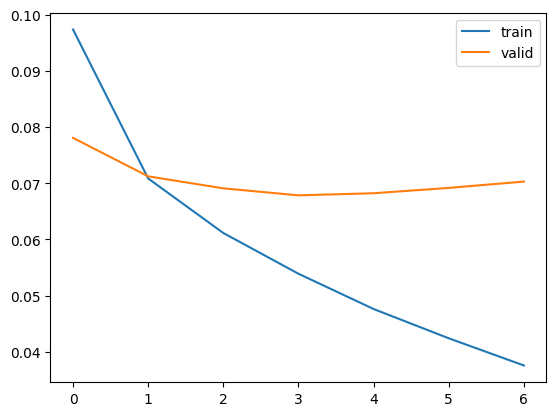

In [48]:
# 训练模型
num_epochs = 7
ls_train = []
ls_valid = []

for epoch in range(num_epochs):

  total_train_loss = 0
  train_acc = 0
  num_train_labels = 0
  for i, batch in enumerate(train_loader):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    output = model(inputs)
    loss = criterion(output, labels.float())

    opt.zero_grad()
    loss.backward()
    opt.step()
    total_train_loss+=loss.item()

    out = torch.round(output)
    train_acc += torch.sum(out==labels)
    num_train_labels += inputs.shape[1]*inputs.shape[0]

  total_val_loss=0
  val_acc = 0
  num_val_labels = 0
  with torch.no_grad():
    for j,batch in enumerate(valid_loader):
      inputs, labels = batch[0].to(device), batch[1].to(device)
      output = model(inputs)
      loss = criterion(output, labels.float())
      total_val_loss+=loss.item()

      out = torch.round(output)
      val_acc += torch.sum(out==labels)
      num_val_labels += inputs.shape[1]*inputs.shape[0]


  ls_train.append(total_train_loss/i)
  ls_valid.append(total_val_loss/j)
  lr_scheduler.step()
  # Print the loss every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss/i}, Training Accuracy: {train_acc/num_train_labels}')
  print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {total_val_loss/j}, Validation Accuracy: {val_acc/num_val_labels}')
  print('')

# plot lines
plt.plot(ls_train, label = "train")
plt.plot(ls_valid, label = "valid")
plt.legend()
plt.show()

# Test model

In [49]:
# Set the model to eval state
model.eval()

BiLSTMModel(
  (embedding): Embedding(6526, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [50]:
# 上传了'测试集.txt'之后可以直接从这里开始
def remove(sentence):
  sentence_no_punct = re.sub(r'[^\w\s]', '', sentence)
  return sentence_no_punct

file_path = "/content/测试集.txt"
dic = []
tests = []
labels = []


with open(file_path, "r") as file:
  for line_number, line in enumerate(file):
    if line.strip() != "":
      seg_text = replace(line)

      sentence = [char for char in seg_text if char !='/']
      dic.extend(sentence)
      # y
      labels_indices = creat_label(seg_text)
      labels.append(labels_indices)
      # x
      tests.append(sentence)

In [51]:
from gensim.models import Word2Vec
Word2Vec_model = Word2Vec(sentences=[dic], vector_size=128, window=5, min_count=1, workers=4)

vocab_list = list(Word2Vec_model.wv.index_to_key)

# match each word with an index (int)
for i in range(0, len(tests)):
  tests[i] = [vocab_list.index(character) for character in tests[i]]


In [52]:
len(tests)

963

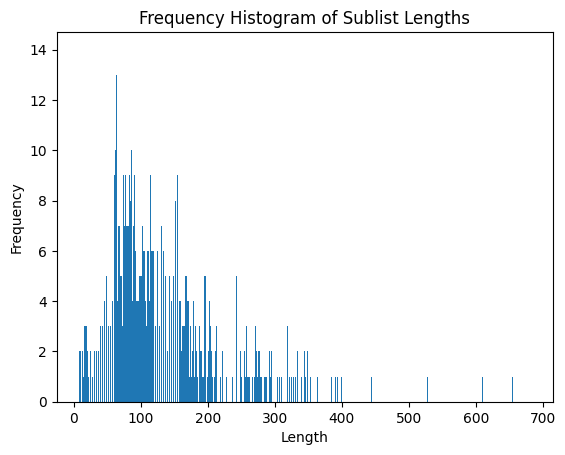

In [53]:
show_frequency(tests)

In [54]:
filtered_inputs = [sublist for sublist in tests if len(sublist) <= 300]
filtered_labels = [sublist for sublist in labels if len(sublist) <= 300]
tests = filtered_inputs
labels = filtered_labels

In [55]:
len(labels)

909

In [56]:
# padding
test_data = pad_sequence([torch.LongTensor(x) for x in tests], batch_first=True, padding_value=0)
test_labels = pad_sequence([torch.LongTensor(x) for x in labels], batch_first=True, padding_value=0)

In [57]:
print(test_data.shape)
print(test_labels.shape)

torch.Size([909, 295])
torch.Size([909, 295])


In [58]:
# load data
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

In [59]:

total_test_loss=0
test_acc = 0
num_test_labels = 0

with torch.no_grad():
  for i,batch in enumerate(test_loader):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    output = model(inputs)

    loss = criterion(output, labels.float())
    total_test_loss+=loss.item()

    out = torch.round(output)
    test_acc += torch.sum(out==labels)
    num_test_labels += inputs.shape[1]*inputs.shape[0]


    text_indices = inputs[0]
    label_indices = output[0]
    true_indices = labels[0]



print(f'Test Loss: {total_test_loss/i}')
print(f'Test Accuracy: {test_acc/num_test_labels}')

Test Loss: 0.3216179719677678
Test Accuracy: 0.9020127058029175


In [60]:
# Choose a threshold
threshold = 0

text = [vocab_list[i] for i in text_indices]

# Apply the threshold to get segmentation decisions
# segmentation_decisions = [1 if x> threshold else 0 for x in label_indices]
segmentation_decisions = torch.round(label_indices)

# Get the segmented result and true segment
segmented_result = ''.join([char + '/' if decision == 1 else char for char, decision in zip(text, segmentation_decisions)])
true_segment = ''.join([char + '/' if decision == 1 else char for char, decision in zip(text, true_indices)])

In [61]:
print(segmented_result)
print(true_segment)

秦伐魏/陈轸合三晋而东谓/齐王曰 古之王者之伐/也欲以正/天下而立/功名以为/后世也今齐楚/燕赵韩梁/六国之递甚/也不足/以立/功名适足/以强秦/而自弱也/非山东之/上计也能危山东者/强秦也不忧/强秦而递/相罢弱而两归其国/于秦此臣之/所以为/山东之/患天下为秦相割秦曾不出力天下为秦相烹秦曾不出薪何秦之智/而山东之/愚耶？愿大王之察也/之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之
秦伐魏/陈轸合三晋而东谓齐王曰/ 古之王者之伐也/欲以正天下而立功名/以为后世也/今齐/楚/燕/赵/韩/梁六国之递甚也/不足以立功名/适足以强秦而自弱也/非山东之上计也/能危山东者/强秦也/不忧强秦/而递相罢弱/而两归其国于秦/此臣之所以为山东之患/天下为秦相割/秦曾不出力/天下为秦相烹/秦曾不出薪/何秦之智而山东之愚耶？愿大王之察也/之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之之
